In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data Ingestion
# Files -> {'KS_AQI_2020.csv', 'KS_AQI_2021.csv', 'KS_AQI_2022.csv', 'KS_AQI_2023.csv'}

import pandas as pd
import glob

path = '/content/drive/MyDrive/835_Final_Project/data_old'
file_prefix = 'KS_AQI_202'

all_data = []

for i in range(0, 4):
    file = f"{path}/{file_prefix}{i}.csv"
    data = pd.read_csv(file)
    all_data.append(data)

all_data = pd.concat(all_data, ignore_index=True)

print(all_data)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/835_Final_Project/data_old/KS_AQI_2020.csv'

In [ ]:
print('-------- MISSING VALUES ------- ')
all_data.isnull().sum()

-------- MISSING VALUES ------- 


Date                          0
Overall AQI Value             0
Main Pollutant                0
Site Name (of Overall AQI)    0
Site ID (of Overall AQI)      0
Source (of Overall AQI)       0
Ozone                         0
PM10                          0
PM25                          0
dtype: int64

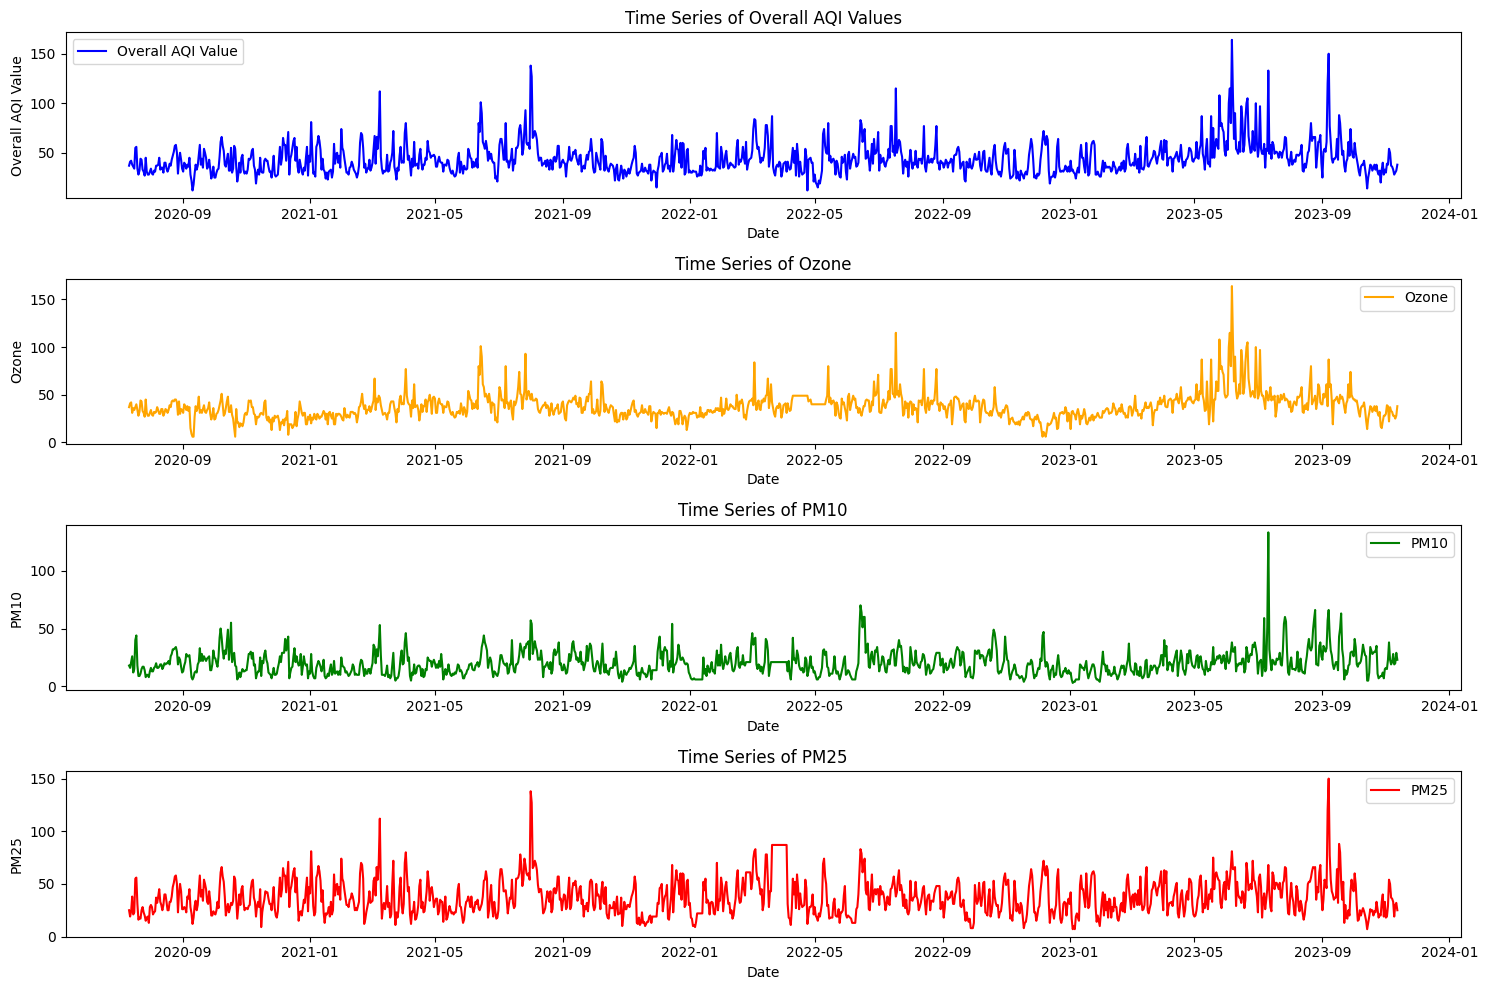

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Converting 'Date' from string to datetime format
all_data['Date'] = pd.to_datetime(all_data['Date'], format='%m/%d/%Y')

# Sorting the dataframe by date
all_data.sort_values('Date', inplace=True)

# Dropping columns not needed for EDA
cols_to_drop = ['Site Name (of Overall AQI)', 'Site ID (of Overall AQI)', 'Source (of Overall AQI)']
all_data = all_data.drop(cols_to_drop, axis=1)

# Converting pollutants to numeric
pollutants = ['Ozone', 'PM10', 'PM25']
for col in pollutants:
    all_data[col] = pd.to_numeric(all_data[col], errors='coerce')

all_data = all_data.fillna(method='ffill').dropna()

plt.figure(figsize=(15, 10))

# Overall AQI Values
plt.subplot(4, 1, 1)
plt.plot(all_data['Date'], all_data['Overall AQI Value'], label='Overall AQI Value', color='blue')
plt.title('Time Series of Overall AQI Values')
plt.xlabel('Date')
plt.ylabel('Overall AQI Value')
plt.legend()

# Ozone
plt.subplot(4, 1, 2)
plt.plot(all_data['Date'], all_data['Ozone'], label='Ozone', color='orange')
plt.title('Time Series of Ozone')
plt.xlabel('Date')
plt.ylabel('Ozone')
plt.legend()

# PM10
plt.subplot(4, 1, 3)
plt.plot(all_data['Date'], all_data['PM10'], label='PM10', color='green')
plt.title('Time Series of PM10')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.legend()

# PM25
plt.subplot(4, 1, 4)
plt.plot(all_data['Date'], all_data['PM25'], label='PM25', color='red')
plt.title('Time Series of PM25')
plt.xlabel('Date')
plt.ylabel('PM25')
plt.legend()

plt.tight_layout()
plt.show()


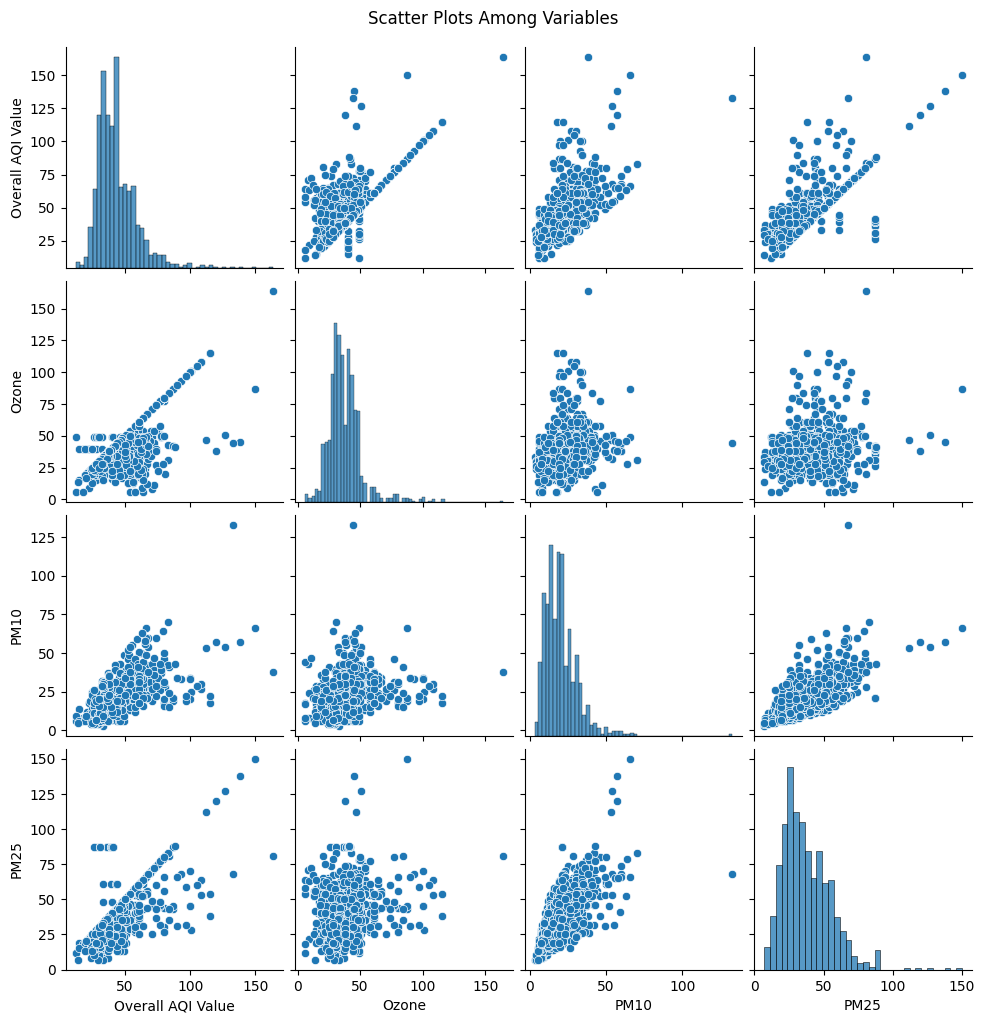

In [ ]:
# Scatter plots
sns.pairplot(all_data[['Overall AQI Value', 'Ozone', 'PM10', 'PM25']])
plt.suptitle('Scatter Plots Among Variables', y=1.02)
plt.show()

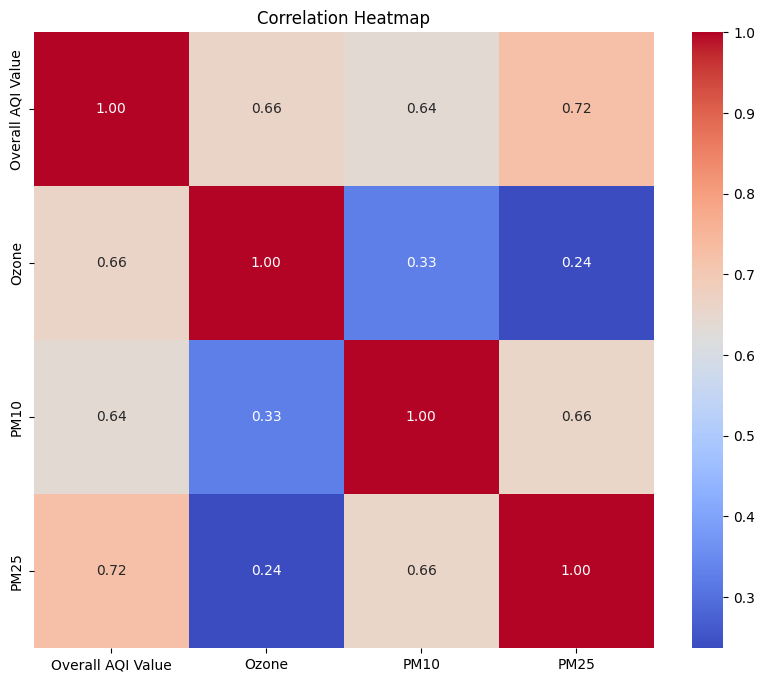

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = all_data.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

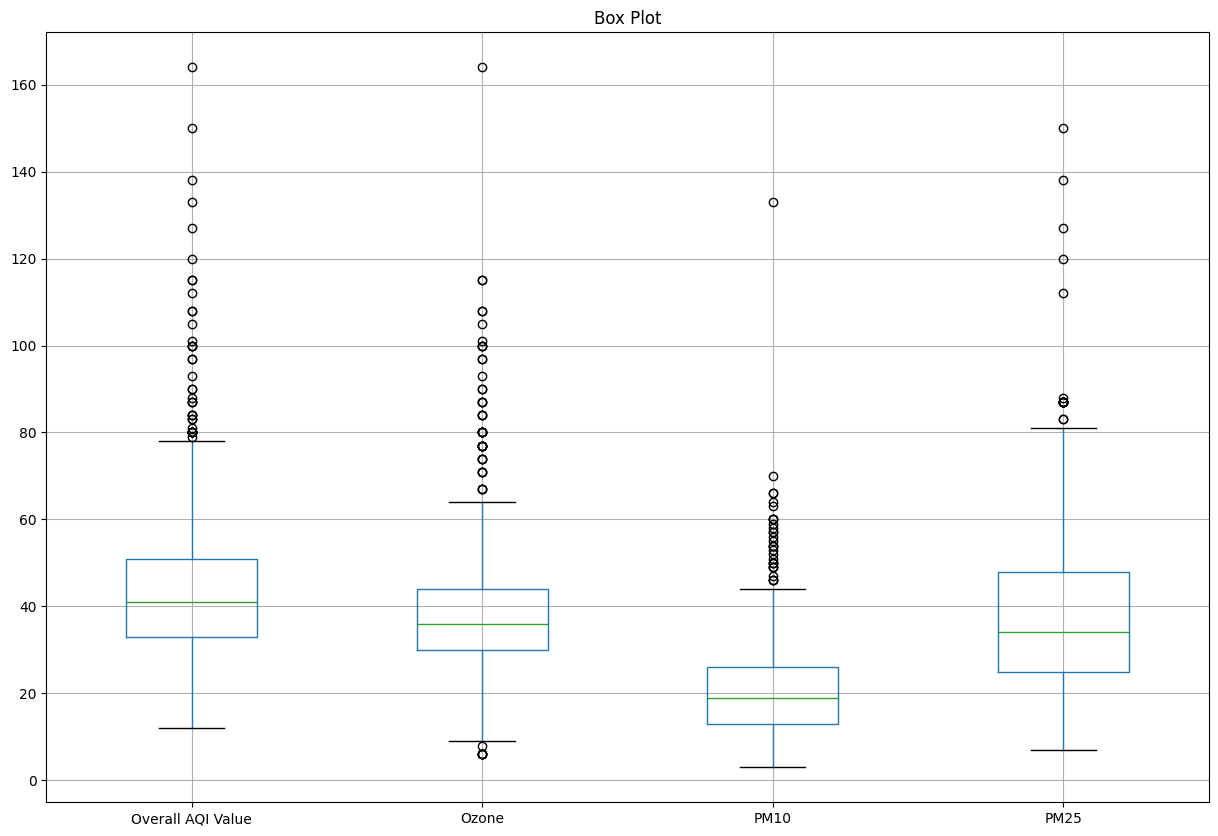

In [ ]:
plt.figure(figsize=(15, 10))
all_data[['Overall AQI Value', 'Ozone', 'PM10', 'PM25']].boxplot()
plt.title("Box Plot")
plt.show()

In [ ]:
# Train - Test Split (80 - 20)%

train_size = int(len(all_data) * 0.8)
test_size = len(all_data) - train_size
train, test = all_data.iloc[0:train_size], all_data.iloc[train_size:len(all_data)]

In [ ]:
import numpy as np

def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

numeric_columns = ['Overall AQI Value', 'Ozone', 'PM10', 'PM25']

train_scaled = scaler.fit_transform(train[numeric_columns])

test_scaled = scaler.transform(test[numeric_columns])

train_scaled = pd.DataFrame(train_scaled, columns=numeric_columns, index=train.index)
test_scaled = pd.DataFrame(test_scaled, columns=numeric_columns, index=test.index)

time_steps = 10

X_train_univariate, y_train_univariate = create_dataset(train_scaled['Overall AQI Value'], train_scaled['Overall AQI Value'], time_steps)
X_test_univariate, y_test_univariate = create_dataset(test_scaled['Overall AQI Value'], test_scaled['Overall AQI Value'], time_steps)

X_train_univariate = X_train_univariate.reshape(X_train_univariate.shape[0], time_steps, 1)
X_test_univariate = X_test_univariate.reshape(X_test_univariate.shape[0], time_steps, 1)

X_train_multivariate, y_train_multivariate = create_dataset(train_scaled[numeric_columns], train_scaled['Overall AQI Value'], time_steps)
X_test_multivariate, y_test_multivariate = create_dataset(test_scaled[numeric_columns], test_scaled['Overall AQI Value'], time_steps)

X_train_multivariate = X_train_multivariate.reshape(X_train_multivariate.shape[0], time_steps, len(numeric_columns))
X_test_multivariate = X_test_multivariate.reshape(X_test_multivariate.shape[0], time_steps, len(numeric_columns))

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    mode='min',
    verbose=1
)

In [ ]:
from sklearn.model_selection import ParameterGrid
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

parameter_grid = {
    'lstm_units': [32, 64, 128],
    'activation_function': ['tanh'],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [5, 7, 10]
}

def create_lstm_model(input_shape, lstm_units, activation_function, optimizer):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=input_shape, activation=activation_function))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def grid_search_lstm(X_train, y_train, X_test, y_test, input_shape, parameter_grid):
    best_loss = np.inf
    best_params = None
    best_history = None

    for params in ParameterGrid(parameter_grid):
        print(f"Testing model with parameters: {params}")
        # Extract batch_size
        batch_size = params['batch_size']
        model_params = {k: v for k, v in params.items() if k != 'batch_size'}

        model = create_lstm_model(input_shape, **model_params)
        history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_split=0.2, verbose=0)
        loss = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Loss: {loss}")

        if loss < best_loss:
            best_loss = loss
            best_params = params
            best_history = history

    return best_params, best_loss, best_history

In [ ]:
best_params_uni, best_loss_uni, best_history_uni = grid_search_lstm(
    X_train_univariate, y_train_univariate, X_test_univariate, y_test_univariate,
    (X_train_univariate.shape[1], 1), parameter_grid
)

best_params_multi, best_loss_multi, best_history_multi = grid_search_lstm(
    X_train_multivariate, y_train_multivariate, X_test_multivariate, y_test_multivariate,
    (X_train_multivariate.shape[1], X_train_multivariate.shape[2]), parameter_grid
)

Testing model with parameters: {'activation_function': 'tanh', 'batch_size': 5, 'lstm_units': 32, 'optimizer': 'adam'}
Test Loss: 1.262372612953186
Testing model with parameters: {'activation_function': 'tanh', 'batch_size': 5, 'lstm_units': 32, 'optimizer': 'rmsprop'}
Test Loss: 1.238662600517273
Testing model with parameters: {'activation_function': 'tanh', 'batch_size': 5, 'lstm_units': 64, 'optimizer': 'adam'}
Test Loss: 1.3295879364013672
Testing model with parameters: {'activation_function': 'tanh', 'batch_size': 5, 'lstm_units': 64, 'optimizer': 'rmsprop'}
Test Loss: 1.2186534404754639
Testing model with parameters: {'activation_function': 'tanh', 'batch_size': 5, 'lstm_units': 128, 'optimizer': 'adam'}
Test Loss: 1.5570274591445923
Testing model with parameters: {'activation_function': 'tanh', 'batch_size': 5, 'lstm_units': 128, 'optimizer': 'rmsprop'}
Test Loss: 1.271880865097046
Testing model with parameters: {'activation_function': 'tanh', 'batch_size': 7, 'lstm_units': 32, 

In [ ]:
# Train univariate model
final_univariate_model = create_lstm_model((X_train_univariate.shape[1], 1),
                                          lstm_units=best_params_uni['lstm_units'],
                                          activation_function=best_params_uni['activation_function'],
                                          optimizer=best_params_uni['optimizer'])
final_univariate_history = final_univariate_model.fit(X_train_univariate, y_train_univariate, epochs=75, batch_size=best_params_uni['batch_size'], validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/75
111/111 [==============================] - 3s 8ms/step - loss: 0.6867 - val_loss: 0.4605
Epoch 2/75
111/111 [==============================] - 1s 5ms/step - loss: 0.6103 - val_loss: 0.4257
Epoch 3/75
111/111 [==============================] - 1s 5ms/step - loss: 0.5839 - val_loss: 0.3802
Epoch 4/75
111/111 [==============================] - 1s 5ms/step - loss: 0.5745 - val_loss: 0.3671
Epoch 5/75
111/111 [==============================] - 1s 5ms/step - loss: 0.5626 - val_loss: 0.3478
Epoch 6/75
111/111 [==============================] - 0s 4ms/step - loss: 0.5596 - val_loss: 0.3566
Epoch 7/75
111/111 [==============================] - 1s 5ms/step - loss: 0.5521 - val_loss: 0.3518
Epoch 8/75
111/111 [==============================] - 1s 5ms/step - loss: 0.5487 - val_loss: 0.3203
Epoch 9/75
111/111 [==============================] - 0s 4ms/step - loss: 0.5471 - val_loss: 0.3235
Epoch 10/75
111/111 [==============================] - 0s 4ms/step - loss: 0.5447 - val_loss: 0.3203

In [ ]:
# Train multivariate model
final_multivariate_model = create_lstm_model((X_train_multivariate.shape[1], X_train_multivariate.shape[2]),
                                             lstm_units=best_params_multi['lstm_units'],
                                             activation_function=best_params_multi['activation_function'],
                                             optimizer=best_params_multi['optimizer'])
final_multivariate_history = final_multivariate_model.fit(X_train_multivariate, y_train_multivariate, epochs=75, batch_size=best_params_multi['batch_size'], validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/75
78/78 [==============================] - 3s 15ms/step - loss: 0.6530 - val_loss: 0.4250
Epoch 2/75
78/78 [==============================] - 0s 5ms/step - loss: 0.5856 - val_loss: 0.3946
Epoch 3/75
78/78 [==============================] - 0s 5ms/step - loss: 0.5686 - val_loss: 0.3762
Epoch 4/75
78/78 [==============================] - 1s 7ms/step - loss: 0.5522 - val_loss: 0.3587
Epoch 5/75
78/78 [==============================] - 1s 7ms/step - loss: 0.5530 - val_loss: 0.3505
Epoch 6/75
78/78 [==============================] - 1s 10ms/step - loss: 0.5444 - val_loss: 0.3444
Epoch 7/75
78/78 [==============================] - 1s 13ms/step - loss: 0.5405 - val_loss: 0.3389
Epoch 8/75
78/78 [==============================] - 1s 13ms/step - loss: 0.5361 - val_loss: 0.3446
Epoch 9/75
78/78 [==============================] - 1s 13ms/step - loss: 0.5311 - val_loss: 0.3317
Epoch 10/75
78/78 [==============================] - 1s 12ms/step - loss: 0.5273 - val_loss: 0.3272
Epoch 11/75
7

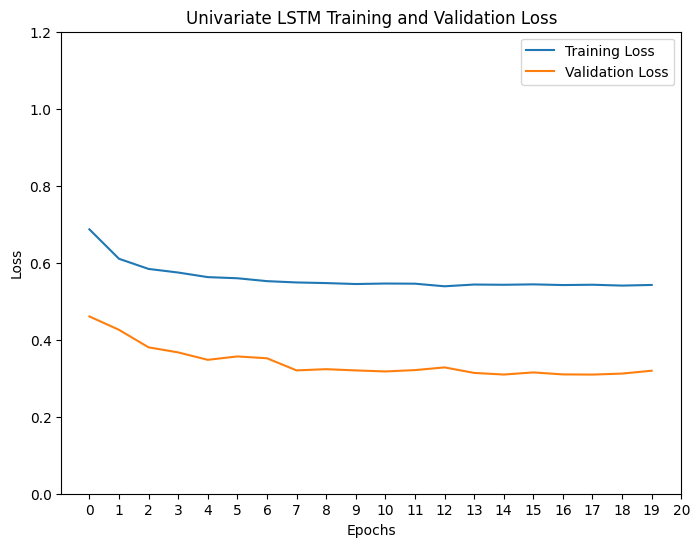

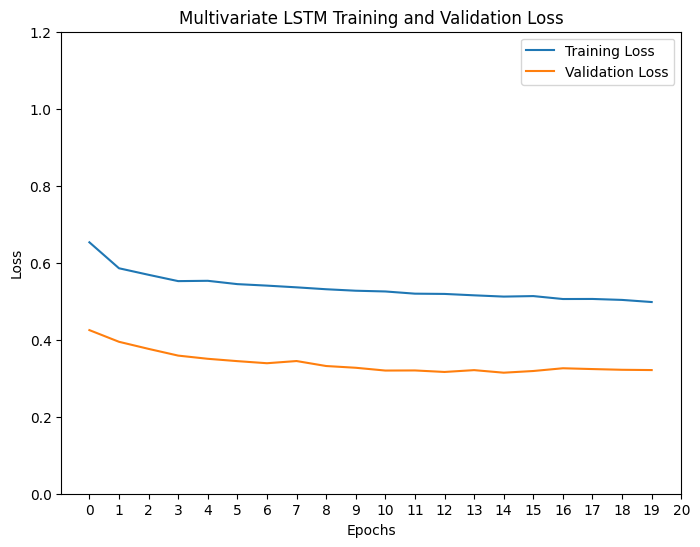

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(final_univariate_history.history['loss'], label='Training Loss')
plt.plot(final_univariate_history.history['val_loss'], label='Validation Loss')
plt.title('Univariate LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,1 * 1.2)
plt.xticks(np.arange(0, 21, 1))
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(final_multivariate_history.history['loss'], label='Training Loss')
plt.plot(final_multivariate_history.history['val_loss'], label='Validation Loss')
plt.title('Multivariate LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 21, 1))
plt.ylim(0,1 * 1.2)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_pred_uni = final_univariate_model.predict(X_test_univariate, verbose=0)

mse_uni = mean_squared_error(y_test_univariate, y_pred_uni)
print(f'\nUnivariate Model MSE: {mse_uni}')

rmse_uni = sqrt(mse_uni)
print(f'\nUnivariate Model RMSE: {rmse_uni}')

y_pred_multi = final_multivariate_model.predict(X_test_multivariate, verbose=0)

mse_multi = mean_squared_error(y_test_multivariate, y_pred_multi)
print(f'\nMultivariate Model MSE: {mse_multi}')

rmse_multi = sqrt(mse_multi)
print(f'\nMultivariate Model RMSE: {rmse_multi}')

print(f'\nTest Dataset Statistics:')
test_scaled['Overall AQI Value'].describe()


Univariate Model MSE: 1.178740879166216

Univariate Model RMSE: 1.0856983370928666

Multivariate Model MSE: 1.122255416939827

Multivariate Model RMSE: 1.0593655728500087

Test Dataset Statistics:


count    244.000000
mean       0.773309
std        1.274194
min       -1.625000
25%        0.000000
50%        0.500000
75%        1.125000
max        7.750000
Name: Overall AQI Value, dtype: float64

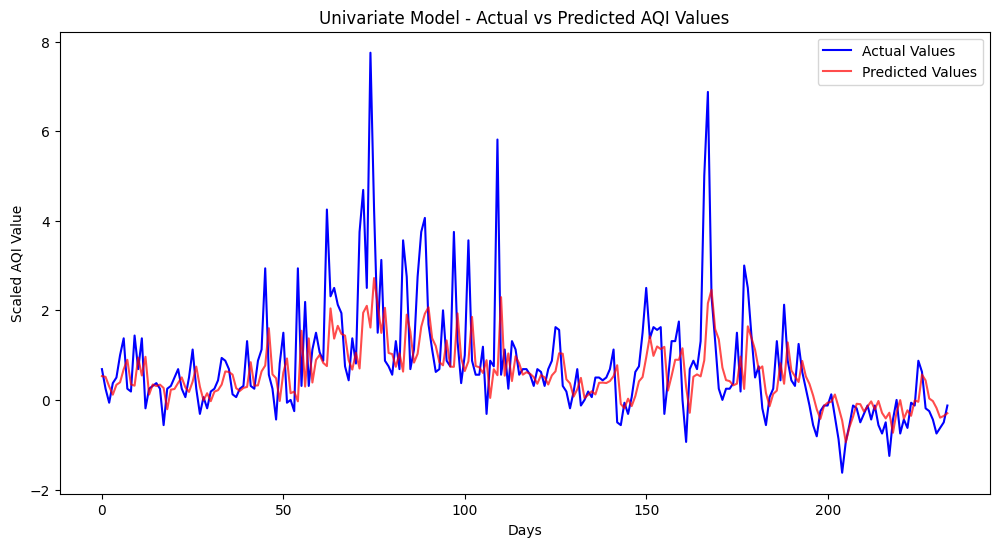

In [ ]:
# Plotting actual vs predicted values for the Univariate Model
plt.figure(figsize=(12, 6))
plt.plot(y_test_univariate, label='Actual Values', color='blue')
plt.plot(y_pred_uni.reshape(-1), label='Predicted Values', color='red', alpha=0.7)
plt.title('Univariate Model - Actual vs Predicted AQI Values')
plt.xlabel('Days')
plt.ylabel('Scaled AQI Value')
plt.legend()
plt.show()

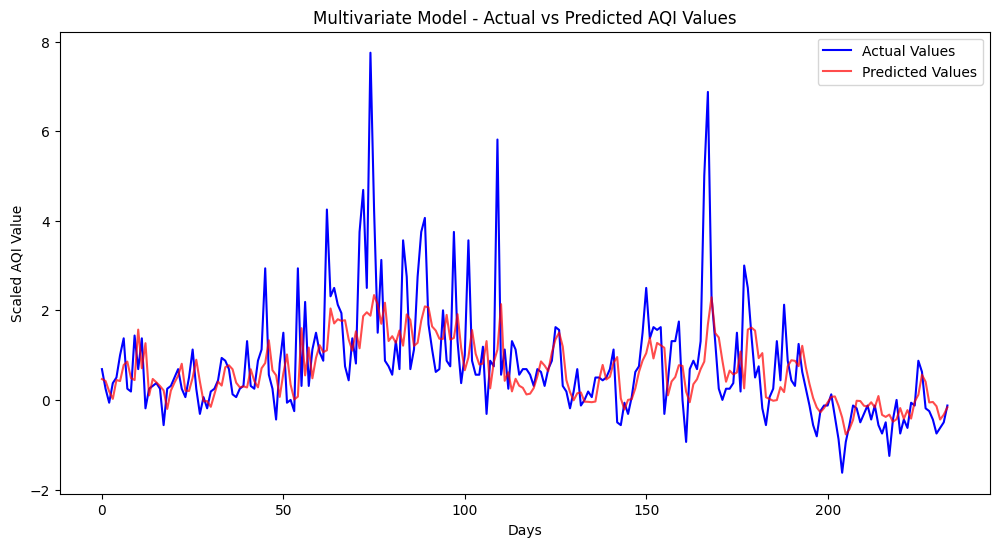

In [ ]:
# Plotting actual vs predicted values for the Multivariate Model
plt.figure(figsize=(12, 6))
plt.plot(y_test_multivariate, label='Actual Values', color='blue')
plt.plot(y_pred_multi.reshape(-1), label='Predicted Values', color='red', alpha=0.7)
plt.title('Multivariate Model - Actual vs Predicted AQI Values')
plt.xlabel('Days')
plt.ylabel('Scaled AQI Value')
plt.legend()
plt.show()

In [ ]:
final_univariate_model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 32)                4352      
                                                                 
 dense_38 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
final_multivariate_model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 32)                4736      
                                                                 
 dense_39 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4769 (18.63 KB)
Trainable params: 4769 (18.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
